In [169]:
#plotter per unire più run e più posterior
#------------------Import--------------------------------
from scipy import interpolate
from scipy import integrate
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os 
import statistics as stat
folder='/home/rciancarella/DarkSirensStat/MyDSStat/results/'
os.chdir(folder)

In [161]:
runpath='FullExp-50_sigmawithcat'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

# DS Cat

In [162]:
all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=2)
all_zs=np.loadtxt(runpath+'_DSs.txt', usecols=3)
dl_max=np.max(all_dls)
dl_min=np.min(all_dls)
dl_med=dl_min+(dl_max-dl_min)/2
idx_max=np.where(all_dls==dl_max)[0][0]
idx_min=np.where(all_dls==dl_min)[0][0]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

idx_med=np.where(all_dls==find_nearest(all_dls, value=dl_med))[0][0]

print(idx_min,idx_max,idx_med)

45 33 49


# $\beta$-Plot

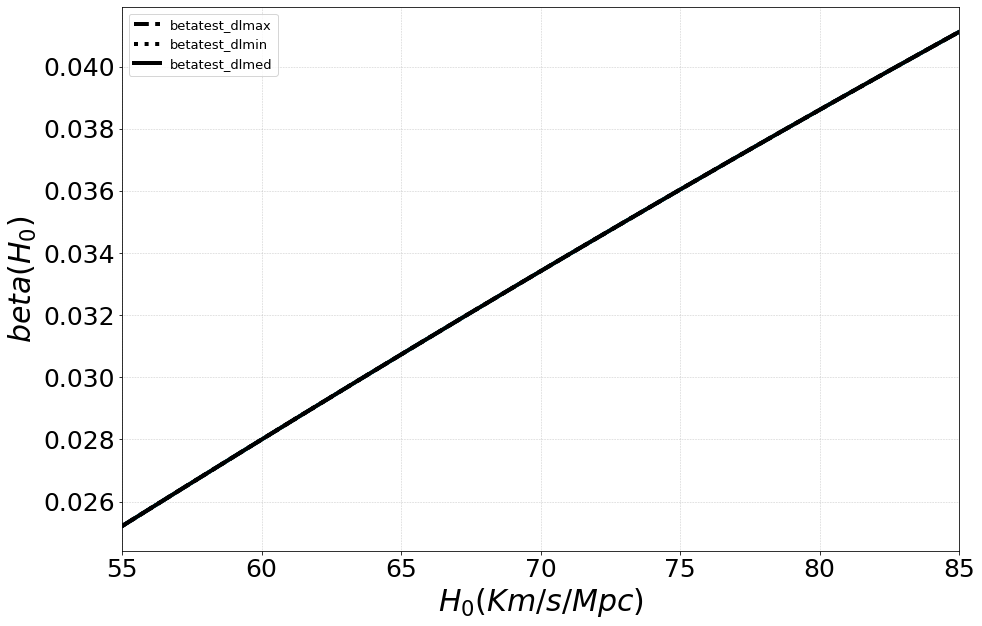

In [163]:
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
betavol=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/volbeta/betatest_beta.txt')
betatest=np.loadtxt(runpath+'_beta.txt')

colors=pl.cm.turbo(np.linspace(0.01,0.99,300))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)

for i in range(len(betatest)):
    ax.plot(x,betatest[i]/np.trapz(betatest[i],x),color=colors[i*2],linewidth=3)#,label='betatest'+str(i))

ax.plot(x,betatest[idx_max]/np.trapz(betatest[idx_max],x),label='betatest_dlmax',color='k',linewidth=4,linestyle='dashed')
ax.plot(x,betatest[idx_min]/np.trapz(betatest[idx_min],x),label='betatest_dlmin',color='k',linewidth=4,linestyle='dotted')
ax.plot(x,betatest[idx_med]/np.trapz(betatest[idx_med],x),label='betatest_dlmed',color='k',linewidth=4,linestyle='solid')
ax.legend(fontsize=13, ncol=1)                     

# Likelihood

In [164]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

In [165]:
NDS=np.shape(likes)[0]
final_post_by_like=[]
for i in range(NDS):
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

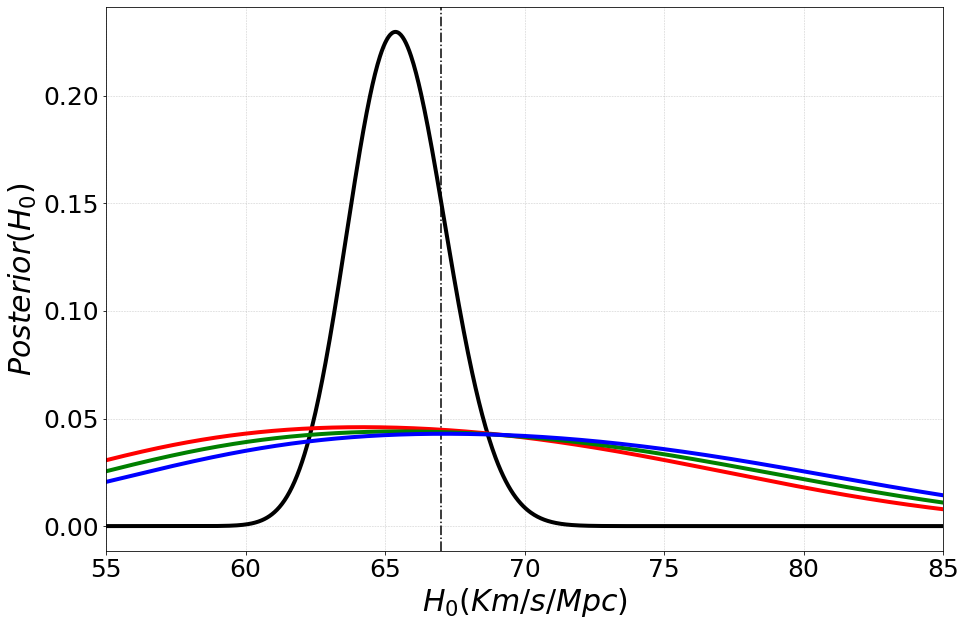

In [166]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')


ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#------------------------------Single posteriors--------------------------------------
toplot=likes[idx_max]/betatest[idx_max]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='solid')

toplot=likes[idx_med]/betatest[idx_med]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')

toplot=likes[idx_min]/betatest[idx_min]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='solid')



# From Posterior

In [167]:
post=np.loadtxt(runpath+'_totpost.txt')

mean=65.48028932090592,std=1.72374797515906 std/mean=2.632468477210467%
mean=65.48028932090591,std=1.72374797515906 std/mean=2.6324684772104674%


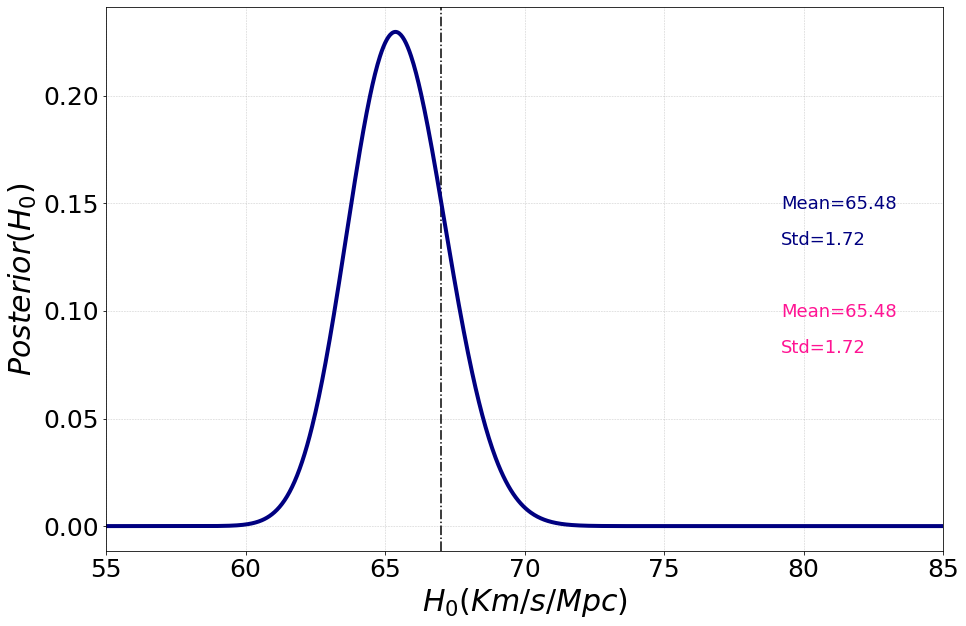

In [168]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

Mycol='navy'
Myshift='deeppink'
ax.plot(x,post/np.trapz(post,x),label='Post',color=Mycol,linewidth=4,linestyle='solid')
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color=Myshift,linewidth=4,linestyle='solid')

newdist=(post)/np.trapz(post,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

dist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c=Myshift)
plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=18, c=Myshift)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))


# Test on the Catalogue

In [59]:
all_dcs=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/FullExplorer.txt',usecols=1)

FileNotFoundError: [Errno 2] No such file or directory

In [35]:
#-----------------test the uniform distribution
position=[]
volume=[]
numobj=[]

Nbis=15
step=(np.max(all_dcs)-np.min(all_dcs))/Nbis
start=np.min(all_dcs)
for i in range(Nbis):
    dcsup=step/2 +start+(step)*i
    position.append(dcsup)
    tmp=all_dcs[all_dcs<dcsup]
    numobj.append(len(tmp))
    volume.append(dcsup**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

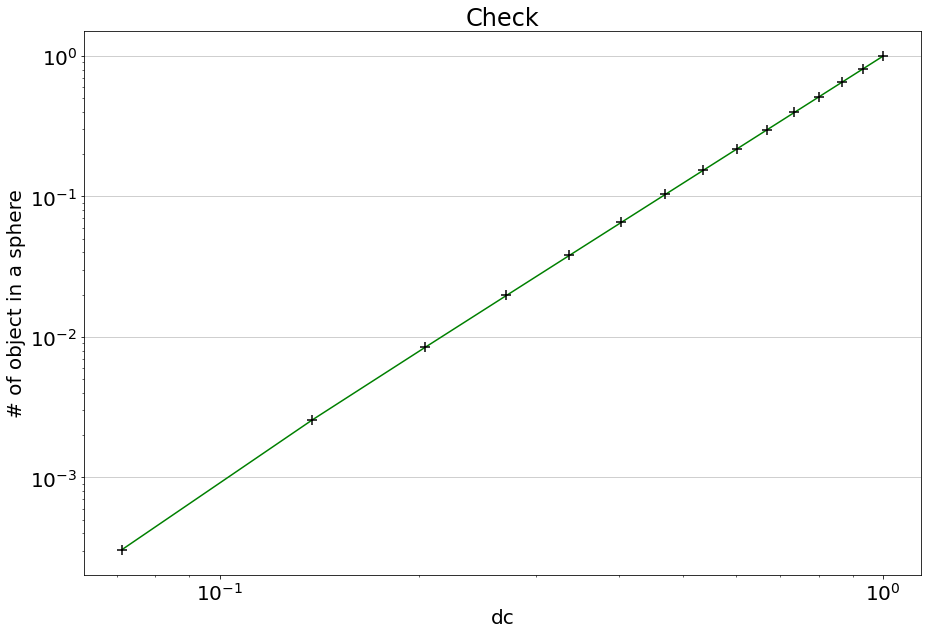

In [36]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position/np.max(position),numobj/np.max(numobj),s=100, marker='+', c='k', zorder=10 )

plt.plot(position/np.max(position),volume/np.max(volume),color='g')

plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

In [170]:
radius_deg= np.sqrt(10/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)

phimin=0
phimax=phimin+5.5*sigma_phi
thetamin=0
thetamax=thetamin+5.5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
phicenter=(phimax-phimin)/2 +phimin
thetacenter=(thetamax-thetamin)/2 +thetamin


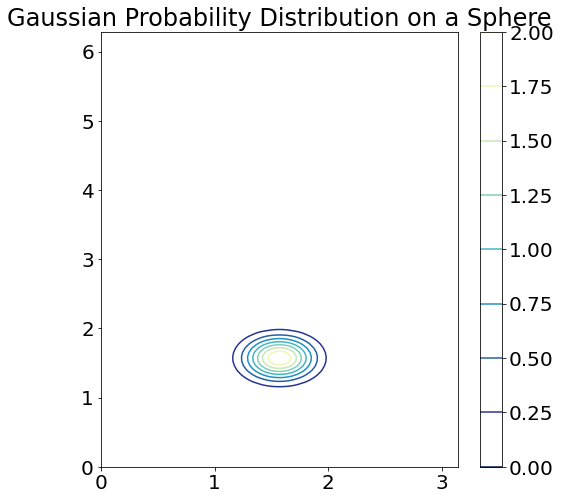

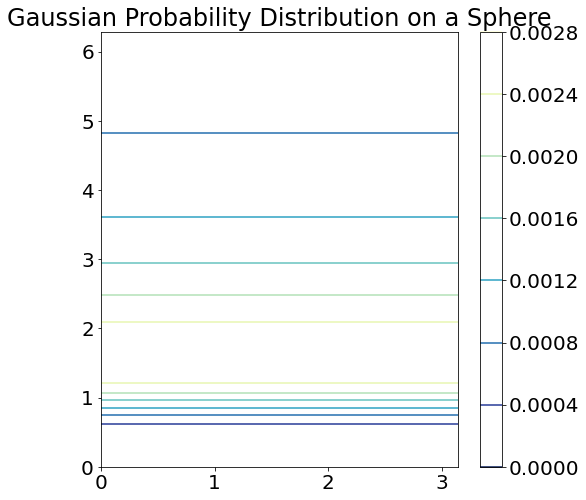

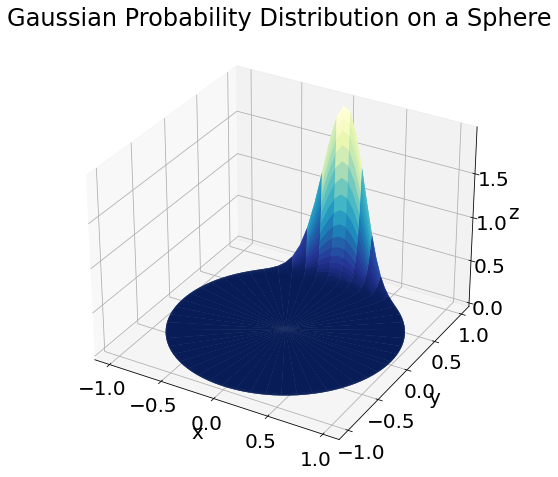

In [227]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import njit


def gaussian_prob_distribution_on_sphere(phi, theta, phi0, theta0, radius, sigma):
    # If input is a single point, convert to a list

    phi = np.array([phi])
    theta = np.array([theta])

    # Calculate the distance from each point to the fixed point
    distances = np.zeros_like(phi)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    dx = x - radius * np.sin(phi0) * np.cos(theta0)
    dy = y - radius * np.sin(phi0) * np.sin(theta0)
    dz = z - radius * np.cos(phi0)
    distances = np.sqrt(dx*dx + dy*dy + dz*dz)

    # Calculate the Gaussian probability distribution for each point
    prob = 1.0/(sigma*np.sqrt(2*np.pi)) * np.exp(-distances*distances/(2*sigma*sigma))

    # If input was a single point, return a single probability value
    if len(prob) == 1:
        return prob[0]

    return prob
# Set up the parameters
phi0 = 0.5 * np.pi
theta0 = np.pi*0.5
radius = 1.0
sigma = 0.2
n = 100

# Generate the set of points on the sphere
theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, n), np.linspace(0, np.pi, n))

# Calculate the Gaussian probability distribution for each point
prob = gaussian_prob_distribution_on_sphere(phi.flatten(), theta.flatten(), phi0, theta0, radius, sigma)

# Reshape the probabilities into the original grid shape
prob = prob.reshape((n, n))

# Convert spherical coordinates to polar coordinates
r = np.sin(phi)
theta = theta

# Generate a contour plot of the Gaussian probability distribution
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_aspect('equal', adjustable='box')
contour = ax.contour(phi, theta, prob, cmap=cm.YlGnBu_r)
# Add a color bar
cbar = fig.colorbar(contour)


# Add labels and title to the plot
ax.set_title('Gaussian Probability Distribution on a Sphere')


# Generate a 3D plot of the Gaussian probability distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Convert spherical coordinates to Cartesian coordinates
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)



# Plot the Gaussian probability distribution as a surface
ax.plot_surface(x, y, prob, cmap=cm.YlGnBu_r)

# Add labels and title to the plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Gaussian Probability Distribution on a Sphere')

# Show the plots
plt.show()


In [201]:
# Create a grid of polar coordinates for the contour plot
n_points = 100
phi_vals = np.linspace(0, np.pi, n_points)
theta_vals = np.linspace(0, 2*np.pi, n_points)
phi_grid, theta_grid = np.meshgrid(phi_vals, theta_vals)

# Calculate the Gaussian probability distribution for each point in the grid
prob_grid = gaussian_prob_distribution_on_sphere(phi_grid, theta_grid, phi0, theta0, radius, sigma)

# Create a polar contour plot of the probability distribution
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.contourf(theta_grid, phi_grid, prob_grid, cmap=cm.YlGnBu_r)
ax.set_rlabel_position(90)
ax.set_title("Gaussian Probability Distribution on a Sphere", va='bottom')
plt.show()

# Create a 3D surface plot of the probability distribution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = radius * np.outer(np.sin(phi_vals), np.cos(theta_vals))
Y = radius * np.outer(np.sin(phi_vals), np.sin(theta_vals))
Z = radius * np.outer(np.cos(phi_vals))
ax.plot_surface(X, Y, Z, cmap=cm.YlGnBu_r, facecolors=cm.YlGnBu_r(prob_grid))
ax.set_title("Gaussian Probability Distribution on a Sphere")
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

In [218]:
import numpy as np
from numba import jit


@jit(nopython=True)
def gaussian_prob_distribution_on_sphere(phi, theta, phi0, theta0, radius, sigma):
    # If input is a single point, convert to a list

    phi = np.array([phi])
    theta = np.array([theta])

    # Calculate the distance from each point to the fixed point
    distances = np.zeros_like(phi)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    dx = x - radius * np.sin(phi0) * np.cos(theta0)
    dy = y - radius * np.sin(phi0) * np.sin(theta0)
    dz = z - radius * np.cos(phi0)
    distances = np.sqrt(dx*dx + dy*dy + dz*dz)

    # Calculate the Gaussian probability distribution for each point
    prob = 1.0/(sigma*np.sqrt(2*np.pi)) * np.exp(-distances*distances/(2*sigma*sigma))

    # If input was a single point, return a single probability value
    if len(prob) == 1:
        return prob[0]

    return prob


In [219]:
val=gaussian_prob_distribution_on_sphere(phi0*0.5,theta0*0.5,phi0,theta0,1,sigma_phi)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mCan't unify return type from the following types: array(float64, 1d, C), float64
[1mReturn of: IR name '$272return_value.3', type 'float64', location: [1m
File "../../../../../tmp/ipykernel_3311607/2261135413.py", line 27:[0m
[1m<source missing, REPL/exec in use?>[0m[0m
[1mReturn of: IR name '$276return_value.1', type 'array(float64, 1d, C)', location: [1m
File "../../../../../tmp/ipykernel_3311607/2261135413.py", line 29:[0m
[1m<source missing, REPL/exec in use?>[0m[0m[0m

In [223]:
phi[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])